# Fit SBML model

In this example, we will try another feature in the FitMulticell pipeline, which enable users to use the already existing feature of Morpheus, which is to use SBML model directly by internally converting them into MorpheusML.

For this example, we will use an SBML model from BioModels, https://www.ebi.ac.uk/biomodels/BIOMD0000000254. The first step will be to install the model and copy the path to the model's xml file. Then we will construct a model object using the recently installed SBML model. 

In [1]:
import pyabc
import fitmulticell as fmc
import scipy as sp
import numpy as np
import pandas as pd
import os
import tempfile
from pathlib import Path
import matplotlib.pyplot as plt

file_ = str((Path(os.getcwd())) / 'models' / 'BIOMD0000000254_url.xml')

par_map = {'V_in': './Global/Constant[@symbol="V_in"]',
           'kp': './Global/Constant[@symbol="kp"]'}
model = fmc.model.MorpheusModel(
    file_, par_map=par_map,
    executable="/usr/local/bin/morpheus",
    show_stdout=False, show_stderr=True,
    raise_on_error=False)


Then, we will convert the SBML model into MorpheusML model. 

In [2]:
MLmodel = model.SBML_to_MorpheusML()

FitMultiCell.Model INFO: SBML model successfully convert to MorpheusML


Now, our model is properly constructed and we can simulate directly from it using some ground truth parameters.

In [3]:
true_pars = {'V_in': 0.36, 'kp': 6}
observed_data = model.sample(true_pars)

lets plot the simulation output for two species, namely T1 and T2.

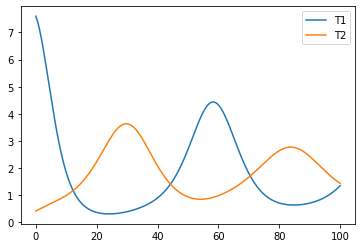

In [4]:
plt.plot(observed_data["time"], observed_data["T1"], label="T1")
plt.plot(observed_data["time"], observed_data["T2"], label="T2")
plt.legend()

Now, let's start the inference process for two parameters (V_in, kp), but before that, let's define all required variables.

In [5]:

limits = {key: (0, 10) for key, val in true_pars.items()}

prior = pyabc.Distribution(**{key: pyabc.RV("uniform", lb, ub - lb)
                              for key, (lb, ub) in limits.items()})

def distance(val1, val2):
    d = np.sum([np.sum(np.abs(val1[key] - val2[key])) \
                for key in ['T1', 'T2']])
    return d

In [6]:
limits

{'V_in': (0, 10), 'kp': (0, 10)}

We can now start the inference process.

In [7]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=20)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")
history = abc.new(db_path, observed_data)
abc.run(max_nr_populations=8)

ABC.Sampler INFO: Parallelize sampling on 12 processes.
ABC.History INFO: Start <ABCSMC id=7, start_time=2022-04-07 12:34:33>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 4.78966521e+05.
ABC INFO: Accepted: 20 / 46 = 4.3478e-01, ESS: 2.0000e+01.
ABC INFO: t: 1, eps: 1.44892639e+05.
ABC INFO: Accepted: 20 / 58 = 3.4483e-01, ESS: 1.6766e+01.
ABC INFO: t: 2, eps: 1.05292104e+04.
ABC INFO: Accepted: 20 / 60 = 3.3333e-01, ESS: 9.2184e+00.
ABC INFO: t: 3, eps: 2.37777556e+03.
ABC INFO: Accepted: 20 / 62 = 3.2258e-01, ESS: 1.9520e+01.
ABC INFO: t: 4, eps: 1.45106353e+03.
ABC INFO: Accepted: 20 / 55 = 3.6364e-01, ESS: 1.8209e+01.
ABC INFO: t: 5, eps: 1.23634676e+03.
ABC INFO: Accepted: 20 / 55 = 3.6364e-01, ESS: 1.7455e+01.
ABC INFO: t: 6, eps: 9.27132245e+02.
ABC INFO: Accepted: 20 / 63 = 3.1746e-01, ESS: 1.7877e+01.
ABC INFO: t: 7, eps: 6.60341867e+02.
ABC INFO: Accepted: 20 / 70 = 2.8571e-01, ESS: 1.8117e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done

Now, we can visualize the obtained Bayesian posterior approximation along with the acceptance threshold 

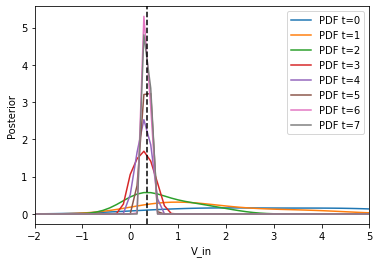

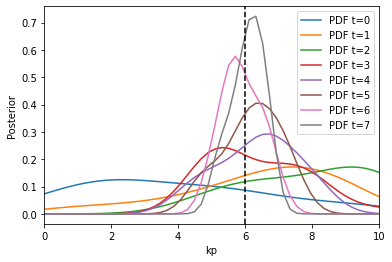

In [9]:
fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df,
        w,
        xmin=-2,
        xmax=5,
        x="V_in",
        xname="V_in",
        ax=ax,
        label=f"PDF t={t}",
    )
ax.axvline(true_pars["V_in"], color="k", linestyle="dashed")
ax.legend();
plt.show()

fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df,
        w,
        xmin=0,
        xmax=10,
        x="kp",
        xname="kp",
        ax=ax,
        label=f"PDF t={t}",
    )
ax.axvline(true_pars["kp"], color="k", linestyle="dashed")
ax.legend();
